In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os

from sklearn.model_selection import train_test_split 
from keras.utils import to_categorical 
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

from keras.models import Sequential 
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input
from keras.layers import Dense, Dropout 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Flatten, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler

#pip install tensorflow-datasets
import tensorflow_datasets as tfds

import datetime

# Create a dataset

In [2]:
batch_size = 32
img_height = 224
img_width = 224

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    r"C:\tmp\dogs-vs-cats\train",
    label_mode='binary',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    r"C:\tmp\dogs-vs-cats\train",
    label_mode='binary',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['Cat', 'Dog']


# Visualize the data

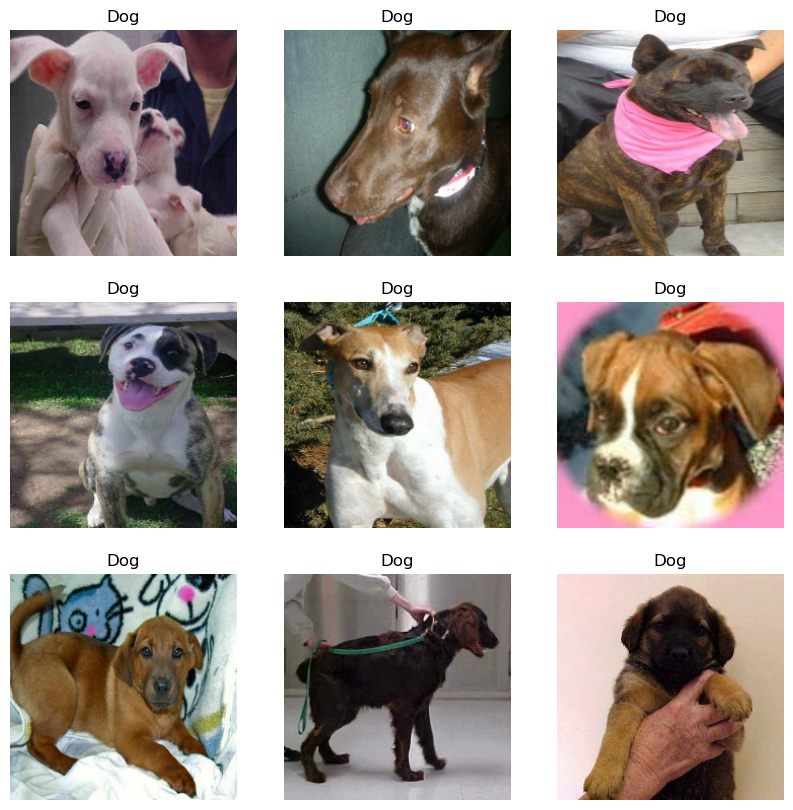

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 1)


# Configure the dataset for performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model

In [9]:
IMG_SIZE = (224, 224)
# Create the base model from the pre-trained model MobileNet V3
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                                    include_top=False,
                                                    weights='imagenet')

In [10]:
base_model.trainable = False

In [11]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

                                                                                                  
 expanded_conv_2/depthwise/Batc  (None, 56, 56, 72)  288         ['expanded_conv_2/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_5 (ReLU)                 (None, 56, 56, 72)   0           ['expanded_conv_2/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_2/project (Conv2  (None, 56, 56, 24)  1728        ['re_lu_5[0][0]']                
 D)                                                                                               
                                                                                                  
 expanded_

                                                                                                  
 re_lu_10 (ReLU)                (None, 28, 28, 120)  0           ['expanded_conv_4/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 120)   0           ['re_lu_10[0][0]']               
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 32)    3872        ['expanded_conv_4/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
          

                                                                                                  
 expanded_conv_5/project/BatchN  (None, 28, 28, 40)  160         ['expanded_conv_5/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_5/Add (Add)      (None, 28, 28, 40)   0           ['expanded_conv_4/Add[0][0]',    
                                                                  'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 28, 28, 240)  9600       ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 multiply_4 (Multiply)          (None, 14, 14, 200)  0           ['expanded_conv_7/depthwise/Batch
                                                                 Norm[0][0]',                     
                                                                  'tf.math.multiply_7[0][0]']     
                                                                                                  
 expanded_conv_7/project (Conv2  (None, 14, 14, 80)  16000       ['multiply_4[0][0]']             
 D)                                                                                               
                                                                                                  
 expanded_conv_7/project/BatchN  (None, 14, 14, 80)  320         ['expanded_conv_7/project[0][0]']
 orm (Batc

                                                                                                  
 expanded_conv_9/depthwise/Batc  (None, 14, 14, 184)  736        ['expanded_conv_9/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_11 (TFOpL  (None, 14, 14, 184)  0          ['expanded_conv_9/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_22 (ReLU)                (None, 14, 14, 184)  0           ['tf.__operators__.add_11[0][0]']
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  (None, 14, 14, 184)  0          ['re_lu_22[0][0]']               
 a)       

 expanded_conv_10/squeeze_excit  (None, 14, 14, 480)  0          ['multiply_10[0][0]',            
 e/Mul (Multiply)                                                 'tf.math.multiply_14[0][0]']    
                                                                                                  
 expanded_conv_10/project (Conv  (None, 14, 14, 112)  53760      ['expanded_conv_10/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_conv_10/project/Batch  (None, 14, 14, 112)  448        ['expanded_conv_10/project[0][0]'
 Norm (BatchNormalization)                                       ]                                
                                                                                                  
 expanded_conv_11/expand (Conv2  (None, 14, 14, 672)  75264      ['expanded_conv_10/project/BatchN
 D)       

 expanded_conv_12/expand/BatchN  (None, 14, 14, 672)  2688       ['expanded_conv_12/expand[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 tf.__operators__.add_18 (TFOpL  (None, 14, 14, 672)  0          ['expanded_conv_12/expand/BatchNo
 ambda)                                                          rm[0][0]']                       
                                                                                                  
 re_lu_29 (ReLU)                (None, 14, 14, 672)  0           ['tf.__operators__.add_18[0][0]']
                                                                                                  
 tf.math.multiply_18 (TFOpLambd  (None, 14, 14, 672)  0          ['re_lu_29[0][0]']               
 a)                                                                                               
          

                                                                                                  
 expanded_conv_13/depthwise (De  (None, 7, 7, 960)   24000       ['multiply_15[0][0]']            
 pthwiseConv2D)                                                                                   
                                                                                                  
 expanded_conv_13/depthwise/Bat  (None, 7, 7, 960)   3840        ['expanded_conv_13/depthwise[0][0
 chNorm (BatchNormalization)                                     ]']                              
                                                                                                  
 tf.__operators__.add_22 (TFOpL  (None, 7, 7, 960)   0           ['expanded_conv_13/depthwise/Batc
 ambda)                                                          hNorm[0][0]']                    
                                                                                                  
 re_lu_33 

 tf.math.multiply_25 (TFOpLambd  (None, 7, 7, 960)   0           ['re_lu_36[0][0]']               
 a)                                                                                               
                                                                                                  
 multiply_18 (Multiply)         (None, 7, 7, 960)    0           ['expanded_conv_14/depthwise/Batc
                                                                 hNorm[0][0]',                    
                                                                  'tf.math.multiply_25[0][0]']    
                                                                                                  
 expanded_conv_14/squeeze_excit  (None, 1, 1, 960)   0           ['multiply_18[0][0]']            
 e/AvgPool (GlobalAveragePoolin                                                                   
 g2D)                                                                                             
          

In [12]:
#setup input shape into the model
INPUT_SHAPE = [None,IMG_SIZE, IMG_SIZE, 3] #batch, height, width, colour channel

# Setup Layers
model = tf.keras.Sequential([
    base_model, # Layer 1 (Input Layer)
    tf.keras.layers.GlobalAveragePooling2D(),
    #tf.keras.layers.Dense(units=512, activation="relu"), # Hidden Layer   
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(units=256, activation="relu"), # Hidden Layer       
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    #tf.keras.layers.Dense(units=1, activation="softmax") # Layer 4 (Output Layer)       
])


# Compiling the model
base_learning_rate = 0.0001
model.compile(
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
      metrics =["accuracy"]
)

# Build Model
model.build(INPUT_SHAPE)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 1)                 961       
                                                                 
Total params: 2,997,313
Trainable params: 961
Non-trainable params: 2,996,352
_________________________________________________________________


# Initial Run

In [13]:
loss0, accuracy0 = model.evaluate(val_ds)

157/157 [==============================] - 56s 349ms/step - loss: 0.7499 - accuracy: 0.6126


In [14]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.75
initial accuracy: 0.61


In [15]:
def create_model_checkpoint(dir, suffix=None):
    modeldir = os.path.join(dir, "Models",
                            datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S"))
    
    model_path = modeldir + "-" + suffix
    print(f"Model will be saved to `{model_path}`")
    return tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_accuracy',save_best_only=True)

In [16]:
# EPOCHS
initial_epochs = 15

# Create callback
checkpoint = create_model_checkpoint("Notebook_Outputs", "dogs&cats_classifier")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=4)

# Model Training
model_history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    validation_freq=1,
                    callbacks=[early_stopping, checkpoint]
                )

Model will be saved to `Notebook_Outputs\Models\2023_01_05-00_32_24-dogs&cats_classifier`
Epoch 1/15
625/625 [==============================] - ETA: 0s - loss: 0.2848 - accuracy: 0.8820

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_05-00_32_24-dogs&cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_05-00_32_24-dogs&cats_classifier\assets


625/625 [==============================] - 354s 483ms/step - loss: 0.2848 - accuracy: 0.8820 - val_loss: 0.1079 - val_accuracy: 0.9750
Epoch 2/15
625/625 [==============================] - ETA: 0s - loss: 0.0918 - accuracy: 0.9741

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_05-00_32_24-dogs&cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_05-00_32_24-dogs&cats_classifier\assets


625/625 [==============================] - 333s 533ms/step - loss: 0.0918 - accuracy: 0.9741 - val_loss: 0.0629 - val_accuracy: 0.9828
Epoch 3/15
625/625 [==============================] - ETA: 0s - loss: 0.0630 - accuracy: 0.9804

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_05-00_32_24-dogs&cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_05-00_32_24-dogs&cats_classifier\assets


625/625 [==============================] - 376s 601ms/step - loss: 0.0630 - accuracy: 0.9804 - val_loss: 0.0482 - val_accuracy: 0.9844
Epoch 4/15
625/625 [==============================] - ETA: 0s - loss: 0.0497 - accuracy: 0.9844

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_05-00_32_24-dogs&cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_05-00_32_24-dogs&cats_classifier\assets


625/625 [==============================] - 351s 562ms/step - loss: 0.0497 - accuracy: 0.9844 - val_loss: 0.0411 - val_accuracy: 0.9854
Epoch 5/15
625/625 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9856

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_05-00_32_24-dogs&cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_05-00_32_24-dogs&cats_classifier\assets


625/625 [==============================] - 336s 538ms/step - loss: 0.0437 - accuracy: 0.9856 - val_loss: 0.0368 - val_accuracy: 0.9862
Epoch 6/15
625/625 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 0.9868

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_05-00_32_24-dogs&cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_05-00_32_24-dogs&cats_classifier\assets


625/625 [==============================] - 347s 556ms/step - loss: 0.0398 - accuracy: 0.9868 - val_loss: 0.0343 - val_accuracy: 0.9864
Epoch 7/15
625/625 [==============================] - ETA: 0s - loss: 0.0368 - accuracy: 0.9876

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_05-00_32_24-dogs&cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_05-00_32_24-dogs&cats_classifier\assets


625/625 [==============================] - 353s 564ms/step - loss: 0.0368 - accuracy: 0.9876 - val_loss: 0.0327 - val_accuracy: 0.9878
Epoch 8/15
625/625 [==============================] - 343s 549ms/step - loss: 0.0352 - accuracy: 0.9883 - val_loss: 0.0312 - val_accuracy: 0.9866
Epoch 9/15
625/625 [==============================] - 341s 546ms/step - loss: 0.0334 - accuracy: 0.9886 - val_loss: 0.0302 - val_accuracy: 0.9878
Epoch 10/15
625/625 [==============================] - 341s 545ms/step - loss: 0.0331 - accuracy: 0.9878 - val_loss: 0.0295 - val_accuracy: 0.9878
Epoch 11/15
625/625 [==============================] - ETA: 0s - loss: 0.0321 - accuracy: 0.9880

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_05-00_32_24-dogs&cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_05-00_32_24-dogs&cats_classifier\assets


625/625 [==============================] - 366s 586ms/step - loss: 0.0321 - accuracy: 0.9880 - val_loss: 0.0292 - val_accuracy: 0.9884
Epoch 12/15
625/625 [==============================] - 339s 542ms/step - loss: 0.0288 - accuracy: 0.9894 - val_loss: 0.0287 - val_accuracy: 0.9882
Epoch 13/15
625/625 [==============================] - 338s 540ms/step - loss: 0.0293 - accuracy: 0.9898 - val_loss: 0.0284 - val_accuracy: 0.9880
Epoch 14/15
625/625 [==============================] - ETA: 0s - loss: 0.0294 - accuracy: 0.9895

INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_05-00_32_24-dogs&cats_classifier\assets


INFO:tensorflow:Assets written to: Notebook_Outputs\Models\2023_01_05-00_32_24-dogs&cats_classifier\assets


625/625 [==============================] - 354s 567ms/step - loss: 0.0294 - accuracy: 0.9895 - val_loss: 0.0281 - val_accuracy: 0.9886
Epoch 15/15
625/625 [==============================] - 347s 555ms/step - loss: 0.0286 - accuracy: 0.9905 - val_loss: 0.0280 - val_accuracy: 0.9886


In [17]:
model.save('dogs&cats_final1_.h5')

# Model Learning Curves (Accuracy/Loss)

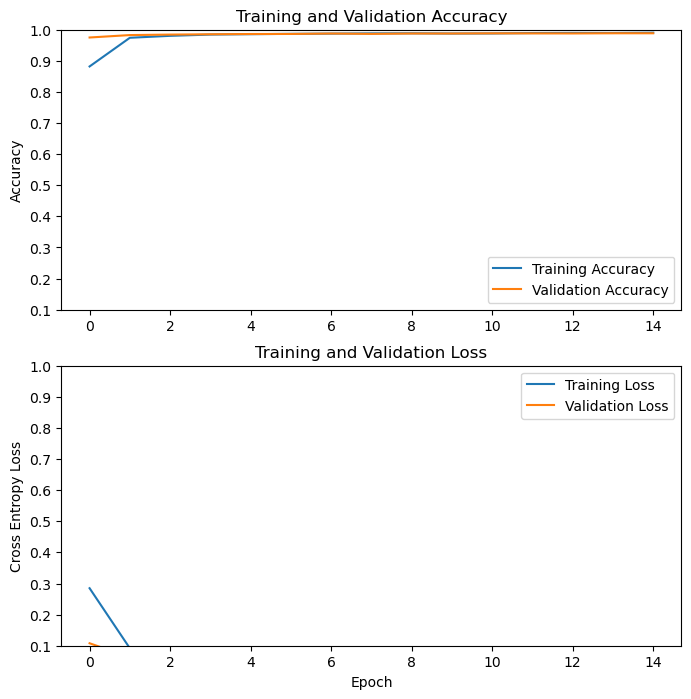

In [18]:
def plot_learning_curves(model_history):
    # retrieve learning metrics history 
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss =model_history.history['val_loss']

    # Plot
    fig = plt.figure(figsize=(8,8))
    ax_acc = plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel("Accuracy")
    plt.ylim([0.1, 1])
    plt.title("Training and Validation Accuracy",)
    
    ax_loss = plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy Loss')
    plt.ylim([0.1,1])
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.show()

plot_learning_curves(model_history)

# Fine Tuning

In [19]:
base_model.trainable = True

In [20]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  263


In [21]:
model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
      metrics =["accuracy"]
)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 1)                 961       
                                                                 
Total params: 2,997,313
Trainable params: 2,863,313
Non-trainable params: 134,000
_________________________________________________________________


In [23]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=model_history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=[early_stopping, checkpoint])

Epoch 15/25
625/625 [==============================] - 672s 1s/step - loss: 5.9265e-08 - accuracy: 0.9356 - val_loss: 6.0964e-08 - val_accuracy: 0.9858
Epoch 16/25
625/625 [==============================] - 658s 1s/step - loss: 5.9265e-08 - accuracy: 0.9338 - val_loss: 6.0964e-08 - val_accuracy: 0.9756
Epoch 17/25
625/625 [==============================] - 654s 1s/step - loss: 5.9265e-08 - accuracy: 0.9378 - val_loss: 6.0964e-08 - val_accuracy: 0.9654
Epoch 18/25
625/625 [==============================] - 661s 1s/step - loss: 5.9265e-08 - accuracy: 0.9377 - val_loss: 6.0964e-08 - val_accuracy: 0.9602


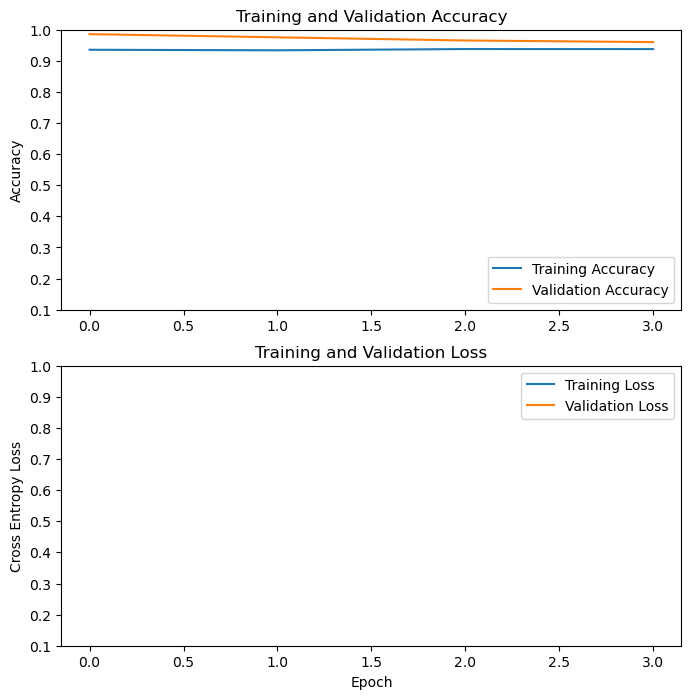

In [24]:
plot_learning_curves(history_fine)

In [25]:
model.save('dogs&cats_final2_.h5')